# Accident Detection



*   Stream a video
*   Extract frames and perform darknet YOLO predictions
*   Read Images and Annotations*
*   Other Pre-processing*
*   Pass data as input to Conv-LSTM net*
*   Show Accident/NotAccident on the video

### Import Relevant Packages

In [1]:
import os
import math
import random
from collections import deque
import time
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Sort out paths and variables

In [2]:
train_data = 'train_data'
val_data = 'val_data'
test_data = 'test_data'

In [9]:
MAX_SEQ_LENGTH = 30
IMG_SIZE = 120
IMG_CHANNELS = 1

train_accident_dir = os.path.join(train_data, 'Accident')
train_notAccident_dir = os.path.join(train_data, 'NotAccident')

test_accident_dir = os.path.join(test_data, 'Accident')
test_notAccident_dir = os.path.join(test_data, 'NotAccident')

val_accident_dir = os.path.join(val_data, 'Accident')
val_notAccident_dir = os.path.join(val_data, 'NotAccident')

num_samples_train_accident = len(os.listdir(train_accident_dir))
num_samples_train_notAccident = len(os.listdir(train_notAccident_dir))
num_samples_train = num_samples_train_accident + num_samples_train_notAccident

num_samples_test_accident = len(os.listdir(test_accident_dir))
num_samples_test_notAccident = len(os.listdir(test_notAccident_dir))
num_samples_test = num_samples_test_accident + num_samples_test_notAccident

num_samples_val_accident = len(os.listdir(val_accident_dir))
num_samples_val_notAccident = len(os.listdir(val_notAccident_dir))
num_samples_val = num_samples_val_accident + num_samples_val_notAccident

print(num_samples_train, num_samples_train_accident, num_samples_train_notAccident)
print(num_samples_val, num_samples_val_accident, num_samples_val_notAccident)
print(num_samples_test, num_samples_test_accident, num_samples_test_notAccident)

3805 1875 1930
600 300 300
515 255 260


### Display Images
The following function takes a directory containing videos, and displays middle frames from 20 random videos.

This is used to display the data and get an idea if our paths and labels are set right.

In [4]:
def display_images_in_dir(dir):
  plt.figure(figsize = (20,20))
  video_folders = os.listdir(dir)
  image_folders_n = random.sample(range(len(video_folders)), 20)
  for i, n in enumerate(image_folders_n):
    image_files = os.listdir(os.path.join(dir, video_folders[n]))
    image = image_files[int(len(image_files)/2)]
    image_path = os.path.join(dir, video_folders[n], image)
    img = cv2.imread(image_path)
    plt.subplot(5, 4, i+1)
    plt.imshow(img)
    plt.axis('off')

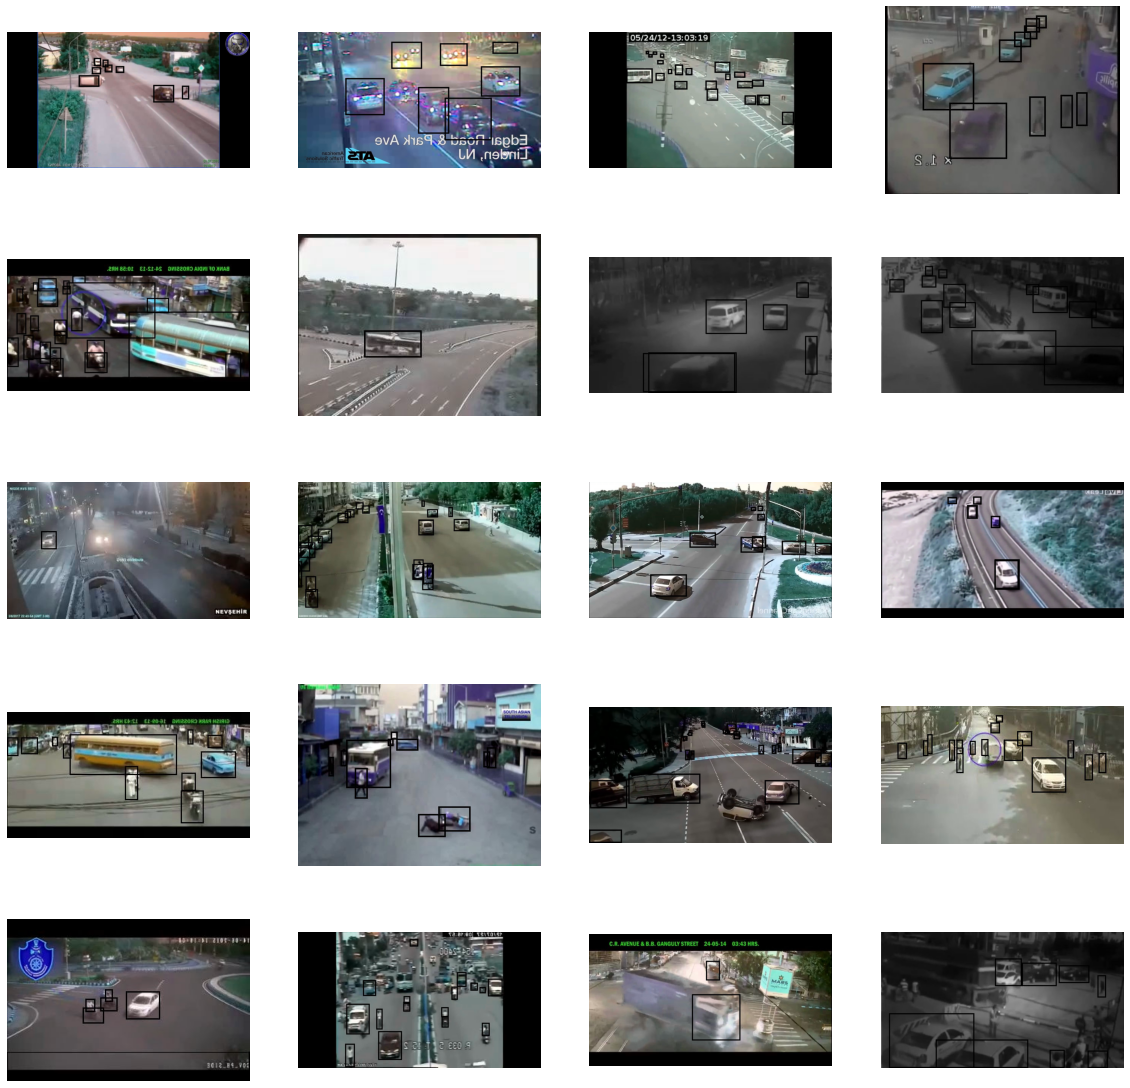

In [7]:
display_images_in_dir(train_accident_dir)

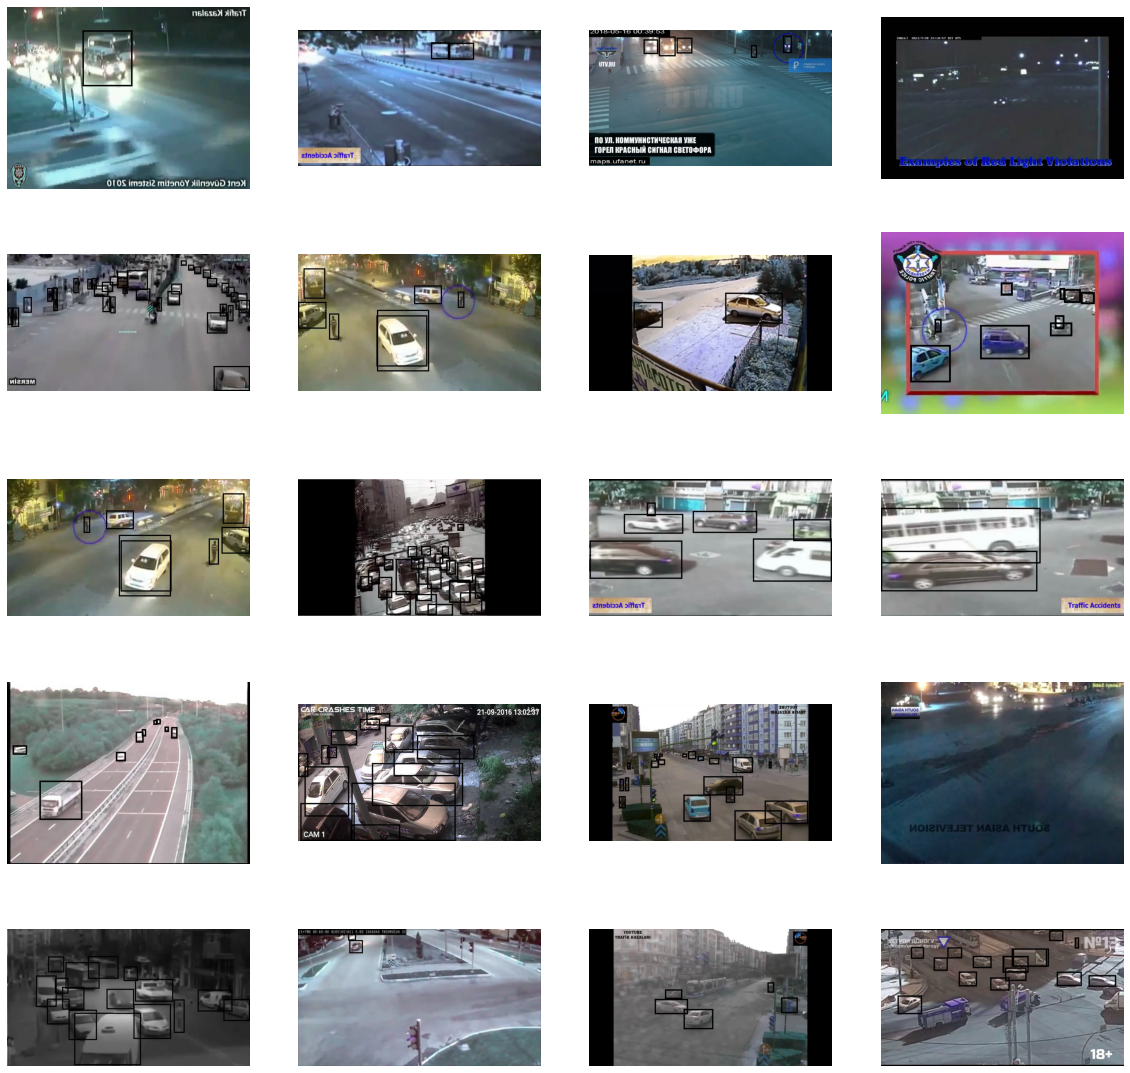

In [8]:
display_images_in_dir(train_notAccident_dir)

## Preprocessing
The preprocessing phase involves different techniques to enhance our data, such as:

- Data Augmentation
- Video Padding
- Convert to Grey Scale
- Downsizing Images
- Normalizing Images

### Image Augmentation
Image augmentation involved horrizontally flipping all the frames in videos since that is what makes most sense considering the nature of our data.

All the images are augmented and stored on disk, hence the function is commented out to not augment without need.


In [5]:
def augment_horrizontal_flip(train_path):
    dir_list0 = os.listdir(train_path)
    print(dir_list0)
    for dir0 in dir_list0:
        dir0_path = os.path.join(train_path, dir0)
        dir_list1 = os.listdir(dir0_path)
#         dir_list1 = sorted_alphanumeric(dir_list1)
        for dir1 in dir_list1:
            dir1_path = os.path.join(dir0_path, dir1)
            dir1_path_aug = dir1_path + '_aug'
            if not os.path.isdir(dir1_path_aug):
                os.mkdir(dir1_path_aug)
            img_list = os.listdir(dir1_path)
            for img in img_list:
                img_path = os.path.join(dir1_path, img)
                img_path_aug = os.path.join(dir1_path_aug, img)
                image = cv2.imread(img_path)
                img_aug = cv2.flip(image, 1)
                cv2.imwrite(img_path_aug, img_aug)
                print(img_path_aug)

In [6]:
# augment_horrizontal_flip("traindata")

Now we check if we really need video padding.

Video padding is only needed if we have videos that have lesser frames than our Sequence Length.

In [7]:
lens = []
for i in os.listdir(train_accident_dir):
  lens.append(len(os.listdir(os.path.join(train_accident_dir, i))))
(pd.DataFrame(lens)<30).sum()

0    31
dtype: int64

We can see the indeed we require video padding here.

### Preprocess Frames
The following function will perform all the preprocessing steps after image augmentation

In [10]:
def preprocess_frames_in_dir(dir, features, masks, start_idx):
  video_names = os.listdir(dir)
  for nth_video, video in enumerate(video_names):
    if os.path.isdir(os.path.join(dir, video)):
      video_path = os.path.join(dir, video)
      video_length = len(os.listdir(video_path))
      length = min(MAX_SEQ_LENGTH, video_length)
      skip_window = math.ceil(video_length/MAX_SEQ_LENGTH)
      count = 0
      image_names = os.listdir(video_path)
      # print("SKIP:", skip_window)
      for i in range(skip_window, video_length, skip_window):
        if image_names[i] == 'Icon_':
          continue
        image_path = os.path.join(video_path, image_names[i])
        img = cv2.imread(image_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        print(image_path)
        resized_img = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE))
        normalized_img = resized_img/255
        features[start_idx + nth_video, count,] = normalized_img
        masks[start_idx + nth_video, count] = 1
        count += 1
  return (features, masks)

Note that we will also need to create masks for video padding ie. to let the model know which frames are padded and which ones are not.

In [ ]:
frame_masks_train = np.zeros(shape=(num_samples_train, MAX_SEQ_LENGTH), dtype="bool")
frame_features_train = np.zeros(
    shape=(num_samples_train, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE), dtype="float32"
)
frame_features, frame_masks = preprocess_frames_in_dir(train_accident_dir, frame_features_train, frame_masks_train, 0)
train_data = preprocess_frames_in_dir(train_notAccident_dir, frame_features_train, frame_masks_train, num_samples_train_accident)



In [ ]:
frame_masks_val = np.zeros(shape=(num_samples_val, MAX_SEQ_LENGTH), dtype="bool")
frame_features_val = np.zeros(
    shape=(num_samples_val, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE), dtype="float32"
)
frame_features, frame_masks = preprocess_frames_in_dir(val_accident_dir, frame_features_val, frame_masks_val, 0)
val_data = preprocess_frames_in_dir(val_notAccident_dir, frame_features_val, frame_masks_val, num_samples_val_accident)


Now we set our class labels, 0 for Accident and 1 for NotAccident

In [16]:
train_labels = np.append(np.zeros(shape = (num_samples_train_accident)), np.ones(shape = (num_samples_train_notAccident)))
val_labels = np.append(np.zeros(shape = (num_samples_val_accident)), np.ones(shape = (num_samples_val_notAccident)))
print(train_labels.shape, val_labels.shape, test_labels.shape)
print(sum(train_labels))
print(train_labels)

(3805,) (600,) (515,)
1930.0
[0. 0. 0. ... 1. 1. 1.]


## Building Our Model
Lets start building our Accident Detection Model.

We will be building a Conv-LSTM network.

### Conv-LSTM Model

In [11]:
#CREATE OUR MODEL
frame_features_input = tf.keras.Input((MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
mask_input = tf.keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
  
#Layers - 1
x = ConvLSTM2D(8, (3, 3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.2, return_sequences = True)(inputs = frame_features_input, mask = mask_input)
x = BatchNormalization()(x)
x = MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = 'channels_last')(x)
x = TimeDistributed(Dropout(0.2))(x)
#Layers - 2
x = ConvLSTM2D(16, (3, 3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.3, return_sequences = True)(x)
x = BatchNormalization()(x)
x = MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = 'channels_last')(x)
x = TimeDistributed(Dropout(0.4))(x)
#Layers - 3
x = ConvLSTM2D(16, (3, 3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.35, return_sequences = True)(x)
x = BatchNormalization()(x)
x = MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = 'channels_last')(x)
x = TimeDistributed(Dropout(0.45))(x)
#Layers - 4
# x = ConvLSTM2D(64, (3, 3), activation = 'tanh', data_format = 'channels_last', recurrent_dropout = 0.2, return_sequences = True)(x)
# x = MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = 'channels_last')(x)
# x = TimeDistributed(Dropout(0.3))(x)
#Flatten
x = Flatten()(x)
#Dense
# x = Dense(128)(x)
# # x = TimeDistributed(Dropout(0.5))(x)
# x = TimeDistributed(Dense(64))(x)
# x = TimeDistributed(Dropout(0.3))(x)
# x = TimeDistributed(Dense(32))(x)
# x = TimeDistributed(Dropout(0.3))(x)
output = Dense(1, activation='sigmoid')(x)
convlstm_model = tf.keras.Model([frame_features_input, mask_input], output)
# convlstm_model.load_weights("weights/best_weights_AD_val_loss")
convlstm_model.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])
convlstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 120, 120 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 30, 118, 118, 2624        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 118, 118, 32          conv_lst_m2d[0][0]           

### Load Weights

In [12]:
convlstm_model.load_weights("best_weights_AD_val_loss")
convlstm_model.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])
convlstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 120, 120 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 30, 118, 118, 2624        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 118, 118, 32          conv_lst_m2d[0][0]           

### Check Points

In [21]:

log_dir = os.path.join('Logs')
filepath = "best_weights_AD"
tb_callback = TensorBoard(log_dir = log_dir)
# lr_plateau = ReduceLROnPlateau(monitor = "val_loss", patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_delta=0.04, verbose=1)
cp_best_val_loss = ModelCheckpoint(
      filepath + "_val_loss", monitor='val_loss', mode = 'min', save_weights_only=True, save_best_only=True, verbose=1
)
cp_best_val_acc = ModelCheckpoint(
      filepath + "_val_acc", monitor='val_accuracy', mode = 'max', save_weights_only=True, save_best_only=True, verbose=1
)
cp_last_5 = ModelCheckpoint(
      filepath + "_last_3", save_weights_only=True, save_freq = num_samples_train, verbose=1
)

### Start training the Model

In [22]:

# ([test_data[0], test_data[1]], test_labels),
convlstm_model_training_history = convlstm_model.fit(x = train_data, y = train_labels, epochs = 500, batch_size = 3, shuffle = True, validation_data = ([val_data[0], val_data[1]], val_labels), callbacks = [cp_best_val_loss, cp_best_val_acc, cp_last_5, tb_callback])


Epoch 1/500
1269/1269 [==============================] - 1607s 1s/step - loss: 0.6452 - accuracy: 0.6484 - val_loss: 0.6366 - val_accuracy: 0.6483

Epoch 00001: val_loss improved from inf to 0.63657, saving model to best_weights_AD_val_loss

Epoch 00001: val_accuracy improved from -inf to 0.64833, saving model to best_weights_AD_val_acc
Epoch 2/500
1269/1269 [==============================] - 1598s 1s/step - loss: 0.5888 - accuracy: 0.6888 - val_loss: 0.7575 - val_accuracy: 0.6800

Epoch 00002: val_loss did not improve from 0.63657

Epoch 00002: val_accuracy improved from 0.64833 to 0.68000, saving model to best_weights_AD_val_acc
Epoch 3/500
1267/1269 [============================>.] - ETA: 2s - loss: 0.5616 - accuracy: 0.7093
Epoch 00003: saving model to best_weights_AD_last_3
1269/1269 [==============================] - 1599s 1s/step - loss: 0.5618 - accuracy: 0.7091 - val_loss: 0.6222 - val_accuracy: 0.6833

Epoch 00003: val_loss improved from 0.63657 to 0.62220, saving model to be

KeyboardInterrupt: 

We interrupted the training as the model started overfitting.


### Testing model on Test data

We start by performing preprocessing steps on our test data

In [ ]:
frame_masks_test = np.zeros(shape=(num_samples_test, MAX_SEQ_LENGTH), dtype="bool")
frame_features_test = np.zeros(
    shape=(num_samples_test, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE), dtype="float32"
)
frame_features, frame_masks = preprocess_frames_in_dir(test_accident_dir, frame_features_test, frame_masks_test, 0)
test_data = preprocess_frames_in_dir(test_notAccident_dir, frame_features_test, frame_masks_test, num_samples_test_accident)
test_labels = np.append(np.zeros(shape = (num_samples_test_accident)), np.ones(shape = (num_samples_test_notAccident)))

In [14]:
# convlstm_model.load_weights("best_weights_AD_best_val_acc")
_, accuracy = convlstm_model.evaluate([test_data[0], test_data[1]], test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

17/17 [==============================] - 41s 2s/step - loss: 0.6504 - accuracy: 0.6796
Test accuracy: 67.96%


### Prediction on a Video
Let us first define a function to send us an alert via Email if an accident is detected.

In [26]:
import smtplib
from email.message import EmailMessage

def send_Alert(to):
    msg = EmailMessage()
    msg.set_content("An accident has been detected")
    msg['subject'] = "Accident detection alert"
    msg['to'] = to


    user = "accident.detection.alert@gmail.com"
    password = "vseungjvvhtzmbfe"

    msg['from'] = user
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    server.login(user, password)
    server.send_message(msg)
    server.quit()

# send_Alert("sulemanzada@gmail.com")

Now that, that is out of the way, lets read frames from our video and pass them to our Conv-LSTM trained model as a sequence, for prediction

Note that for the next step, You will need to set up Darknet with weights and cfg to be able to perform prediction.

As it is just a pipeline, we can still preform prediction without the object detection model in place so here it goes:

In [34]:
# from google.colab.patches import cv2_imshow
video_file_path = os.path.join('predict_vids', 'vid6.mp4')
output_file_path = os.path.join('predict_vids', 'output6.avi')
frames_mask = np.ones(shape=(MAX_SEQ_LENGTH), dtype="bool")
obj_det_path = "/home/suleman/VG_AlexeyAB_darknet/"
darknet_path = obj_det_path + "darknet"
obj_data = obj_det_path + "build/darknet/x64/data/obj.data"
cfg = obj_det_path + "cfg/yolo-obj.cfg"
weights = obj_det_path + "weights/yolo-obj_last.weights"
obj_pred = obj_det_path + "predictions.jpg"
vid_path = 'vid7.mp4'
vid_out_path = 'vid7out.mp4'
# Initialize the VideoCapture object to read from the video file.
video_reader = cv2.VideoCapture(vid_path)

# Get the width and height of the video.
original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize the VideoWriter Object to store the output video in the disk.
video_writer = cv2.VideoWriter(vid_out_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

# Declare a queue to store video frames.
frames_queue = deque(maxlen = MAX_SEQ_LENGTH)

frame_rate = 15
prev = 0
# Initialize a variable to store the predicted action being performed in the video.
predicted_label = ''

# Iterate until the video is accessed successfully.
email = False
acc_frame_count = 0
while video_reader.isOpened():

    # time_elapsed = time.time() - prev
    cv2.waitKey(100)
    # Read the frame.
    ok, frame = video_reader.read() 
    
    # Check if frame is not read properly then break the loop.
    if not ok:
        break
#     cv2.imwrite('frame.jpg', frame)
#     out = subprocess.run("/home/suleman/VG_AlexeyAB_darknet/darknet detector test /home/suleman/VG_AlexeyAB_darknet/build/darknet/x64/data/obj.data /home/suleman/VG_AlexeyAB_darknet/cfg/yolo-obj.cfg /home/suleman/VG_AlexeyAB_darknet/weights/yolo-obj_last.weights /home/suleman/Accident_detection/frame.jpg -dont_show", shell=True)
#     pred_frame = cv2.imread(frame)
    # if time_elapsed > 1./frame_rate:
    #   prev = time.time()
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize the Frame to fixed Dimensions.
    resized_frame = cv2.resize(gray_frame, (IMG_SIZE, IMG_SIZE))
    
    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
    normalized_frame = resized_frame / 255

    # Appending the pre-processed frame into the frames list.
    frames_queue.append(normalized_frame)

    # Check if the number of frames in the queue are equal to the fixed sequence length.
    if len(frames_queue) == MAX_SEQ_LENGTH:

        # Pass the normalized frames to the model and get the predicted probabilities.
        predicted_labels_probabilities = convlstm_model.predict([np.expand_dims(frames_queue, axis = 0), np.expand_dims(frames_mask, axis = 0)])[0]

        if predicted_labels_probabilities < 0.5:
          acc_frame_count += 1
          if acc_frame_count >=5 and not email:
            email = True
            send_Alert("sulemanzada@gmail.com")
          predicted_label = f'Accident ({predicted_labels_probabilities})'
        else:
          predicted_label = f'NotAccident ({predicted_labels_probabilities})'

      # Write predicted class name on top of the frame.
    cv2.putText(frame, predicted_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Write The frame into the disk using the VideoWriter Object.
    video_writer.write(frame)
    cv2.imshow('Prediction', frame)

# Release the VideoCapture and VideoWriter objects.

video_reader.release()
video_writer.release()
